<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [24]:
import numpy as np
import gensim
import os
import re


import pyLDAvis.gensim

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [14]:
amazon = pd.read_csv("amazon.csv")

def tokenize(text):
  split_text = re.sub(r"[^A-Za-z\ ]", "", text).lower().strip().split()
  split_text = [i for i in split_text if i not in STOPWORDS]
  return split_text

amazon.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [25]:
id2word = corpora.Dictionary([tokenize(i) for i in amazon["reviews.text"]])
corpus = [id2word.doc2bow(tokenize(i)) for i in amazon["reviews.text"]]

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=5,
                   workers=4,
                   num_topics = 10 # You can change this parameter
                  )
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.021052  0.001498       1        1  11.633161
4     -0.006488  0.045084       2        1  11.491355
5     -0.032740 -0.004510       3        1  11.107357
0     -0.017119 -0.016990       4        1  10.053207
6     -0.014299 -0.001034       5        1  10.003385
3      0.002982 -0.032934       6        1   9.884314
8      0.050860  0.002195       7        1   9.590508
9     -0.005435  0.011276       8        1   8.991348
1      0.026156 -0.000314       9        1   8.970222
7      0.017136 -0.004271      10        1   8.275152, topic_info=     Category         Freq     Term        Total  loglift  logprob
22    Default  9237.000000    great  9237.000000  30.0000  30.0000
4811  Default  6624.000000   tablet  6624.000000  29.0000  29.0000
3504  Default  2760.000000   kindle  2760.000000  28.0000  28.0000
18    Default  4792.000000    price  4792.000000  27.0000  27.0000
24    Default  2266.000000     long  2266.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
491   Topic10   102.337563    store   957.072083   0.2563  -5.5634
809   Topic10   109.697182    games  1692.974365  -0.2446  -5.4939
627   Topic10   112.215111      old  2168.527344  -0.4695  -5.4712
3     Topic10   107.802025  battery  1909.031250  -0.3821  -5.5113
3504  Topic10   107.801743   kindle  2760.909912  -0.7511  -5.5113

[816 rows x 6 columns], token_table=      Topic      Freq Term
term                      
57        1  0.061515   aa
57        2  0.098424   aa
57        3  0.086121   aa
57        4  0.076279   aa
57        5  0.088582   aa
...     ...       ...  ...
2715      6  0.266640   yr
2715      7  0.032650   yr
2715      8  0.068020   yr
2715      9  0.024487   yr
2715     10  0.029929   yr

[2747 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 6, 1, 7, 4, 9, 10, 2, 8])

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling

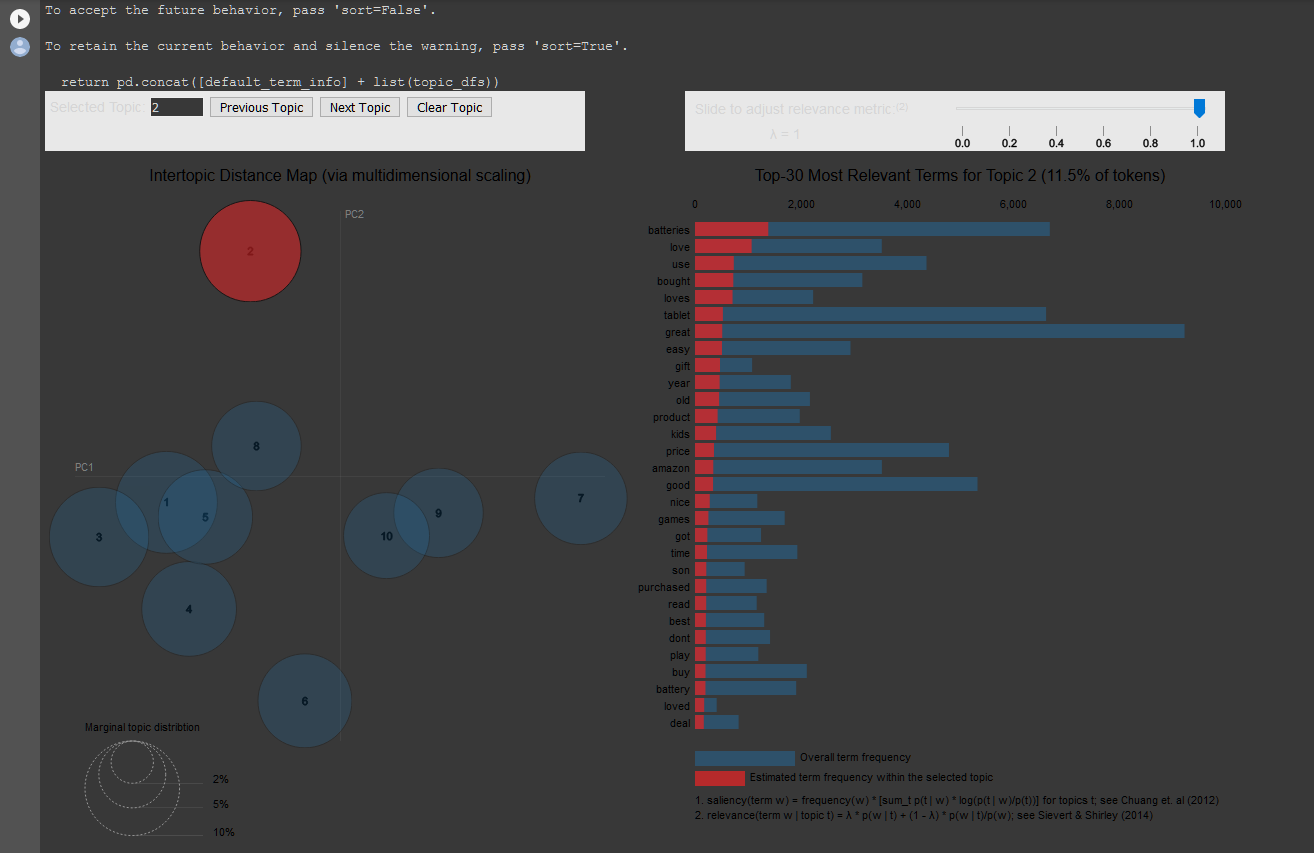